# Model Poisoning Attack for Federated Learning 

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# import necessary dependencies
import sys
sys.path.append('/content/drive/MyDrive/Project')
import argparse
import os, sys
import pickle
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import copy
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# from torchtoolbox.transform import Cutout

from tools.dataset import CIFAR10
from torch.utils.data import DataLoader,Dataset
from record import save_variable, load_variable
from models import ResNet20, CNNCifar, CNNCifar_2
from datasplit import cifar_iid, cifar_noniid, cifar_noniid_simple, cifar_noniid_simple2, cifar_noniid_simple3
from FL import DatasetSplit, LocalUpdate, average_weights
from aggregation import multi_krum, tr_mean
from model_attack import attacking_trimmed_mean, attacking_krum, compute_lambda


### Local Clients Setup

In [2]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        inputs, targets = self.dataset[self.idxs[item]]
        return torch.tensor(inputs), torch.tensor(targets)    
  
    
###################################  Modified  ####################
class LocalUpdate(object):
    def __init__(self, dataset, idxs, Gweight):
        self.trainloader, self.validloader, self.testloader = self.train_val_test(
            dataset, list(idxs))
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Default criterion set to NLL loss function
        self.criterion = nn.CrossEntropyLoss().to(self.device)

    def train_val_test(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.8*len(idxs))]
        idxs_val = idxs[int(0.8*len(idxs)):int(0.9*len(idxs))]
        idxs_test = idxs[int(0.9*len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size=50, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test),
                                batch_size=int(len(idxs_test)/10), shuffle=False)
        return trainloader, validloader, testloader

    def update_weights(self, model, Gweight):
        # Set mode to train model
        model.train()
        if Gweight != None:
            model.load_state_dict(Gweight)
        epoch_loss = []

        # Set optimizer for the local updates
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0001)  ## 0.01

        for iter in range(3):
            batch_loss = []
            for batch_idx, (inputs, targets) in enumerate(self.trainloader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                model.zero_grad()
                outputs = model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return  model.parameters(), sum(epoch_loss) / len(epoch_loss)
      
    def inference(self, model):
        """ Returns the inference accuracy and loss.
        """

        model.eval()
        loss, total, correct = 0.0, 0.0, 0.0

        for batch_idx, (inputs, targets) in enumerate(self.testloader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Inference
            outputs = model(inputs)
            batch_loss = self.criterion(outputs, targets.long())
            loss += batch_loss.item()

            # Prediction
            _, pred_targets = torch.max(outputs, 1)
            pred_targets = pred_targets.view(-1)
            correct += torch.sum(torch.eq(pred_targets, targets)).item()
            total += len(targets)

        accuracy = correct/total
        return accuracy, loss
    

In [3]:
#############################################
# specify preprocessing function
transform_train = transforms.Compose([
    
    transforms.RandomCrop(32,4),
#     Cutout(0.5),
    transforms.RandomHorizontalFlip(),        
   # transforms.RandomRotation(5),
   # transforms.RandomGrayscale(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
]) 

transform_val =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
])
#############################################

In [4]:
# do NOT change these
# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

val_loader = DataLoader(
    val_set, 
    batch_size= VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified


In [5]:
# specify the device for computation
#############################################
# your code here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# global_net = ResNet20(Block)
global_net = CNNCifar()
global_net.to(device)
#############################################
criterion = nn.CrossEntropyLoss().to(device)


### Federated Training and Attack Process

  
*   Change n_attackers to decide how many local modelare crafted (Less than 50%)

*   Change n_clients to decide how many work devices will work in each epoch
*   Change attack to decide which attack method will use (tr_mean, krum)
*   Change aggregation to decide which aggregation rule will use (mean,tr_mean, median, and krum)



In [40]:
# some hyperparameters
# total number of training epochs
EPOCHS = 100
n_attackers=0
n_clients=20
attack='tr_mean'
aggregation='tr_mean'

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"



###########   Use different type of Data :    IID, NON-IID (1 CLASS/ 2 CLASS/ 3 CLASS)  ##########
user_groups = cifar_iid(train_set, n_clients)
#user_groups = cifar_noniid(train_set, n_clients)
# user_groups = cifar_noniid_simple2(train_set, K)


######################### Training ##############################################
# start the training/validation process
best_val_acc = 0
current_learning_rate = 0.01
print("==> Training starts!")
print("="*50)

train_loss, train_accuracy = [], []
Validation_acc_global = []

##############  Initialize all the clients model#################################

client_models = {i: CNNCifar().to(device) for i in range(n_clients)}

########################  Training begins   #####################################
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {i+1} |\n')
    local_weights_1=[]

    # switch to train mode
    global_net.train()
    print("Epoch %d:" %(i+1))
    #Get global weights
    global_weights = global_net.state_dict()
    #Initialize local model
    local_model = {j: LocalUpdate(dataset=train_set,idxs=user_groups[j],Gweight = global_weights) for j in range(n_clients)}

    #Train each client model
    for idx in range(n_attackers,n_clients):
        w1, loss = local_model[idx].update_weights(model=client_models[idx], Gweight = global_weights)
        #local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
        #Change each model's parameter's to list， we have n_client*[[62006]]
        param_grad=[]
        for param in w1:
            param_grad=param.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.data.view(-1)))
        #Merge together [20,62006]
        local_weights_1=param_grad[None, :] if len(local_weights_1)==0 else torch.cat((local_weights_1,param_grad[None,:]), 0)

    #########################Attack here#########################################
    if n_attackers !=0:
        print('attack')
        agg_weights=torch.mean(local_weights_1,dim=0)
        deviation=torch.sign(agg_weights)
        if attack=='mean'or attack=='tr_mean' or attack=='median':
            malicious_weights=attacking_trimmed_mean(local_weights_1,deviation,n_attackers)
        else:
            malicious_weights = attacking_krum(local_weights_1, agg_weights, deviation, n_attackers)


    ######################Update global weights##################################
    ##Here return a list: global_weights_one [[62006]]
    if aggregation=='mean':
        if n_attackers!=0:
            global_weights_one=torch.mean(malicious_weights, 0)
        else:
            global_weights_one=torch.mean(local_weights_1, 0)
    elif aggregation=='tr_mean':
        if n_attackers!=0:
            global_weights_one=tr_mean(malicious_weights, n_attackers)
        else:
            global_weights_one=tr_mean(local_weights_1, 5)
    elif aggregation=='median':
        if n_attackers!=0:
            global_weights_one=torch.median(malicious_weights,0)[0]
        else:
            global_weights_one=torch.median(local_weights_1,0)[0]
    else:
        if n_attackers!=0:
            global_weights_one, krum_candidate = multi_krum(malicious_weights, n_attackers, multi_k=True)
        else:
            global_weights_one, krum_candidate = multi_krum(local_weights_1, n_attackers, multi_k=True)


    ##Change the dimension of the list: global_weights_list, as net parameters' dimension
    start_idx=0
    global_weights_list=[]
    for param in global_net.parameters():
        param_=global_weights_one[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
        start_idx=start_idx+len(param.data.view(-1))
        param_=param_.cuda()
        global_weights_list.append(param_)
    ##Change the list to dict
    global_weights_dict={}
    v=0
    for key in global_weights:
        global_weights_dict[key]=global_weights_list[v]
        v+=1
    ##Update parameters
    global_net.load_state_dict(global_weights_dict)
    

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    

    ####################### Training accuracy ###################################
    global_net.eval()
    list_acc, list_loss = [], []
    
    for c in range(n_clients):
        local_model = LocalUpdate(dataset=train_set,idxs=user_groups[idx],Gweight = None)
        acc, loss = local_model.inference(model=global_net)
        list_acc.append(acc)
        list_loss.append(loss)
        train_accuracy.append(sum(list_acc)/len(list_acc))
    print(f' \nAvg Training Stats after {i+1} global rounds:')
    print(f'Training Loss : {np.mean(np.array(train_loss))}')
    print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))


    ########################### Test accuracy ###################################
    # Validate on the validation dataset
    # switch to eval mode
    global_net.eval()  
    total_examples = 0
    correct_examples = 0   
    val_loss = 0

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            outputs = global_net(inputs)        
            loss = criterion(outputs, targets.long())
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            total_examples+=targets.shape[0]
            correct_examples+=correct.item()
            val_loss+=loss

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    Validation_acc_global.append(avg_acc)
    filename = save_variable(Validation_acc_global,'accuracy4.txt')

    ###################save the model############################################
    # if avg_acc > best_val_acc:
    #     best_val_acc = avg_acc
    #     if not os.path.exists(CHECKPOINT_PATH):
    #         os.makedirs(CHECKPOINT_PATH)
    #     print("Saving ...")
    #     state = {'state_dict': global_net.state_dict(),
    #             'epoch': i,
    #             'lr': current_learning_rate}
    #     torch.save(state, os.path.join(CHECKPOINT_PATH, 'Simplenn.pth'))
        
    print('')
    
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
print(Validation_acc_global)

==> Training starts!

 | Global Training Round : 1 |

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 
Avg Training Stats after 1 global rounds:
Training Loss : 2.215370997786522
Train Accuracy: 25.67% 



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation loss: 2.0563, Validation accuracy: 0.2478


 | Global Training Round : 2 |

Epoch 2:
 
Avg Training Stats after 2 global rounds:
Training Loss : 2.1211996679228764
Train Accuracy: 32.67% 

Validation loss: 1.8651, Validation accuracy: 0.3132


 | Global Training Round : 3 |

Epoch 3:
 
Avg Training Stats after 3 global rounds:
Training Loss : 2.042266944657873
Train Accuracy: 36.64% 

Validation loss: 1.7113, Validation accuracy: 0.3766


 | Global Training Round : 4 |

Epoch 4:
 
Avg Training Stats after 4 global rounds:
Training Loss : 1.9801955710958552
Train Accuracy: 39.24% 

Validation loss: 1.6322, Validation accuracy: 0.4020


 | Global Training Round : 5 |

Epoch 5:
 
Avg Training Stats after 5 global rounds:
Training Loss : 1.9302464731865459
Train Accuracy: 40.24% 

Validation loss: 1.5744, Validation accuracy: 0.4168


 | Global Training Round : 6 |

Epoch 6:
 
Avg Training Stats after 6 global rounds:
Training Loss : 1.8893449752878997
Train Accuracy: 42.29% 

V

### Compare Result

<function matplotlib.pyplot.show>

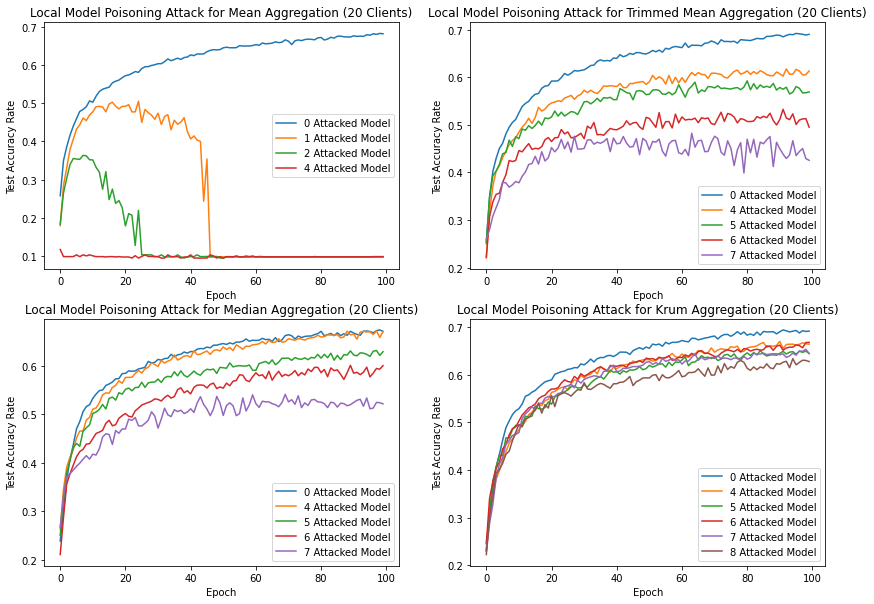

In [41]:
import matplotlib.pyplot as plt

Validation_acc_global_0=[0.2582, 0.35, 0.3864, 0.4162, 0.44, 0.4598, 0.4786, 0.4836, 0.4908, 0.506, 0.5026, 0.5184, 0.5306, 0.5364, 0.5394, 0.5418, 0.5532, 0.5574, 0.5604, 0.5666, 0.5718, 0.5738, 0.5778, 0.5826, 0.5806, 0.5904, 0.5952, 0.5956, 0.5986, 0.6004, 0.6032, 0.6032, 0.6084, 0.6156, 0.611, 0.6142, 0.6176, 0.6144, 0.6192, 0.6206, 0.6262, 0.6242, 0.6286, 0.6284, 0.6288, 0.6346, 0.638, 0.6398, 0.6392, 0.64, 0.6446, 0.6462, 0.6448, 0.6448, 0.645, 0.6502, 0.6492, 0.6494, 0.6494, 0.6506, 0.653, 0.6512, 0.6572, 0.655, 0.6558, 0.6568, 0.6602, 0.6582, 0.6592, 0.6654, 0.662, 0.653, 0.663, 0.6652, 0.6634, 0.6662, 0.6674, 0.6668, 0.6656, 0.6706, 0.6716, 0.665, 0.6674, 0.6722, 0.67, 0.6748, 0.6752, 0.6734, 0.673, 0.6728, 0.676, 0.6744, 0.6752, 0.6744, 0.6788, 0.6776, 0.6812, 0.6798, 0.6822, 0.6814]
Validation_acc_global_1=[0.1804, 0.2848, 0.3314, 0.379, 0.4058, 0.4322, 0.4438, 0.4612, 0.4546, 0.4692, 0.4776, 0.491, 0.4918, 0.49, 0.4774, 0.498, 0.5026, 0.4922, 0.4852, 0.4916, 0.492, 0.4962, 0.4772, 0.4774, 0.5052, 0.4498, 0.4838, 0.4752, 0.4688, 0.458, 0.474, 0.4444, 0.465, 0.47, 0.4306, 0.4556, 0.4452, 0.4506, 0.4622, 0.4262, 0.4066, 0.4146, 0.4036, 0.4002, 0.244, 0.3544, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988]
Validation_acc_global_2=[0.184, 0.2656, 0.3042, 0.3396, 0.3556, 0.3542, 0.3534, 0.3638, 0.3626, 0.3524, 0.3518, 0.3324, 0.3202, 0.2752, 0.3214, 0.2482, 0.2758, 0.2384, 0.2458, 0.2276, 0.1796, 0.2116, 0.2072, 0.1286, 0.2202, 0.104, 0.104, 0.104, 0.104, 0.0994, 0.0994, 0.104, 0.0988, 0.0988, 0.0988, 0.0988, 0.104, 0.0984, 0.0956, 0.0984, 0.0994, 0.0994, 0.104, 0.0994, 0.0994, 0.0998, 0.0988, 0.0994, 0.0998, 0.0956, 0.0956, 0.0994, 0.0988, 0.0988, 0.0994, 0.0988, 0.0988, 0.1012, 0.0994, 0.1012, 0.0984, 0.0998, 0.0994, 0.0984, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988]
Validation_acc_global_4=[0.118, 0.0994, 0.0994, 0.0994, 0.0994, 0.104, 0.0992, 0.104, 0.1012, 0.104, 0.1014, 0.0994, 0.0994, 0.0994, 0.0984, 0.0994, 0.0994, 0.0984, 0.0994, 0.0984, 0.0984, 0.0984, 0.0956, 0.1018, 0.0956, 0.0998, 0.104, 0.0998, 0.0998, 0.0994, 0.0994, 0.0956, 0.0956, 0.104, 0.0994, 0.0994, 0.0994, 0.0956, 0.0984, 0.0984, 0.104, 0.0956, 0.0956, 0.0956, 0.0956, 0.0956, 0.104, 0.1012, 0.0956, 0.0994, 0.0956, 0.0988, 0.0994, 0.0988, 0.1012, 0.0988, 0.0988, 0.0988, 0.0988, 0.0994, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0994, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0988, 0.0994, 0.0994, 0.0994, 0.0994]
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(2,2,1)
ax.plot(range(100),Validation_acc_global_0,label='0 Attacked Model')
ax.plot(range(100),Validation_acc_global_1,label='1 Attacked Model')
ax.plot(range(100),Validation_acc_global_2,label='2 Attacked Model')
ax.plot(range(100),Validation_acc_global_4,label='4 Attacked Model')
ax.set_title('Local Model Poisoning Attack for Mean Aggregation (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="right")
plt.show




Validation_acc_global_0=[0.2388, 0.301, 0.365, 0.4074, 0.4366, 0.4698, 0.4846, 0.505, 0.5156, 0.5192, 0.5324, 0.5412, 0.5484, 0.5496, 0.559, 0.562, 0.566, 0.5726, 0.573, 0.5834, 0.5838, 0.589, 0.5882, 0.5888, 0.593, 0.5944, 0.5964, 0.6084, 0.6052, 0.6066, 0.6126, 0.611, 0.6144, 0.6148, 0.623, 0.6178, 0.622, 0.6232, 0.6278, 0.6256, 0.6288, 0.6284, 0.6336, 0.635, 0.6346, 0.638, 0.6364, 0.6418, 0.6418, 0.6438, 0.6452, 0.6434, 0.6466, 0.6444, 0.6482, 0.6482, 0.65, 0.6546, 0.65, 0.652, 0.6516, 0.652, 0.656, 0.6532, 0.654, 0.6498, 0.6574, 0.6492, 0.6526, 0.6616, 0.6634, 0.6612, 0.6546, 0.6606, 0.6576, 0.6598, 0.6606, 0.6608, 0.6636, 0.6656, 0.6704, 0.6612, 0.6636, 0.666, 0.6614, 0.6672, 0.6616, 0.6654, 0.6622, 0.6704, 0.6668, 0.664, 0.6622, 0.6706, 0.671, 0.67, 0.6672, 0.6718, 0.6732, 0.6702]
Validation_acc_global_4=[0.2636, 0.3454, 0.3912, 0.4116, 0.427, 0.4508, 0.4652, 0.4652, 0.4878, 0.4934, 0.5102, 0.5128, 0.5232, 0.5396, 0.5438, 0.543, 0.555, 0.559, 0.5686, 0.5634, 0.5754, 0.5756, 0.5758, 0.5834, 0.59, 0.5844, 0.5932, 0.5962, 0.6054, 0.6022, 0.598, 0.6104, 0.605, 0.609, 0.6118, 0.6218, 0.6112, 0.615, 0.6194, 0.6204, 0.617, 0.6304, 0.6224, 0.6234, 0.6268, 0.6298, 0.623, 0.6306, 0.6324, 0.63, 0.6382, 0.6328, 0.6372, 0.6306, 0.6426, 0.6384, 0.6336, 0.6398, 0.6392, 0.6426, 0.6432, 0.6448, 0.6494, 0.6442, 0.6518, 0.6474, 0.648, 0.655, 0.6478, 0.6492, 0.6552, 0.6534, 0.652, 0.6552, 0.6544, 0.6522, 0.6558, 0.657, 0.658, 0.6622, 0.6586, 0.6596, 0.663, 0.6628, 0.6622, 0.6634, 0.657, 0.6588, 0.6708, 0.663, 0.6648, 0.6542, 0.6688, 0.6702, 0.669, 0.6694, 0.6638, 0.6714, 0.6576, 0.67]
Validation_acc_global_5=[0.2506, 0.3258, 0.3792, 0.4044, 0.4314, 0.4396, 0.4338, 0.4648, 0.4718, 0.478, 0.5012, 0.5044, 0.5096, 0.5198, 0.5106, 0.5324, 0.535, 0.5288, 0.544, 0.541, 0.551, 0.5536, 0.548, 0.5548, 0.555, 0.5656, 0.555, 0.5644, 0.5658, 0.566, 0.5722, 0.5652, 0.5748, 0.5778, 0.5764, 0.5872, 0.5788, 0.589, 0.5798, 0.5762, 0.582, 0.5886, 0.5828, 0.58, 0.5882, 0.5924, 0.591, 0.5928, 0.5838, 0.5962, 0.5954, 0.5944, 0.6054, 0.5972, 0.5988, 0.5998, 0.599, 0.5988, 0.601, 0.5904, 0.59, 0.604, 0.6062, 0.6084, 0.6036, 0.6116, 0.6016, 0.6068, 0.615, 0.615, 0.6152, 0.6106, 0.6164, 0.6136, 0.6128, 0.6158, 0.612, 0.6168, 0.6154, 0.6228, 0.6152, 0.623, 0.616, 0.6252, 0.611, 0.621, 0.6122, 0.6224, 0.6216, 0.63, 0.6216, 0.62, 0.6262, 0.6254, 0.623, 0.6188, 0.6294, 0.6308, 0.6208, 0.6284]
Validation_acc_global_6=[0.211, 0.287, 0.3562, 0.3772, 0.3948, 0.4122, 0.4228, 0.4274, 0.4382, 0.4392, 0.4496, 0.4602, 0.463, 0.4666, 0.481, 0.4872, 0.476, 0.4782, 0.4914, 0.4968, 0.5012, 0.4956, 0.494, 0.5068, 0.5124, 0.5186, 0.5214, 0.524, 0.5266, 0.5314, 0.5302, 0.527, 0.5342, 0.5388, 0.533, 0.5362, 0.5502, 0.5542, 0.544, 0.548, 0.5416, 0.555, 0.5596, 0.56, 0.5592, 0.5538, 0.5612, 0.5638, 0.5524, 0.556, 0.5534, 0.5638, 0.5584, 0.5676, 0.5692, 0.581, 0.58, 0.5696, 0.5668, 0.5768, 0.585, 0.579, 0.581, 0.573, 0.5882, 0.5698, 0.58, 0.5882, 0.5774, 0.5818, 0.5788, 0.583, 0.5896, 0.579, 0.5854, 0.5806, 0.5928, 0.5876, 0.5962, 0.5962, 0.5852, 0.5918, 0.577, 0.595, 0.5894, 0.591, 0.5818, 0.5714, 0.5852, 0.6004, 0.5842, 0.586, 0.5812, 0.5862, 0.5966, 0.5766, 0.5844, 0.594, 0.5924, 0.5998]
Validation_acc_global_7=[0.267, 0.332, 0.3708, 0.3774, 0.3848, 0.3926, 0.3992, 0.4072, 0.4146, 0.4074, 0.4176, 0.4158, 0.4288, 0.4528, 0.4596, 0.458, 0.4376, 0.4662, 0.4606, 0.4694, 0.4694, 0.4896, 0.4872, 0.493, 0.476, 0.4756, 0.481, 0.4874, 0.5048, 0.496, 0.4712, 0.49, 0.5122, 0.4986, 0.4948, 0.509, 0.5052, 0.508, 0.5012, 0.5044, 0.511, 0.5034, 0.5228, 0.5358, 0.5196, 0.5104, 0.4968, 0.5104, 0.5364, 0.5226, 0.4972, 0.5178, 0.5232, 0.5172, 0.4968, 0.5012, 0.5334, 0.5064, 0.5192, 0.5396, 0.5216, 0.5138, 0.5266, 0.5252, 0.5252, 0.5214, 0.5194, 0.5152, 0.5236, 0.5406, 0.5252, 0.5296, 0.5202, 0.5378, 0.5134, 0.5232, 0.5178, 0.5292, 0.5302, 0.5252, 0.5246, 0.5216, 0.5134, 0.5246, 0.5228, 0.5144, 0.5226, 0.5216, 0.5172, 0.5194, 0.524, 0.5284, 0.5306, 0.5162, 0.5332, 0.511, 0.5124, 0.5242, 0.5234, 0.5212]
ax = fig.add_subplot(2,2,3)
ax.plot(range(100),Validation_acc_global_0,label='0 Attacked Model')
ax.plot(range(100),Validation_acc_global_4,label='4 Attacked Model')
ax.plot(range(100),Validation_acc_global_5,label='5 Attacked Model')
ax.plot(range(100),Validation_acc_global_6,label='6 Attacked Model')
ax.plot(range(100),Validation_acc_global_7,label='7 Attacked Model')
ax.set_title('Local Model Poisoning Attack for Median Aggregation (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="lower right")
plt.show



Validation_acc_global_0=[0.2548, 0.347, 0.4022, 0.4296, 0.4504, 0.4614, 0.481, 0.495, 0.5052, 0.5114, 0.5254, 0.5388, 0.5452, 0.5496, 0.5586, 0.5644, 0.566, 0.577, 0.5816, 0.5826, 0.5922, 0.592, 0.5928, 0.5994, 0.608, 0.6044, 0.6084, 0.6142, 0.6132, 0.6144, 0.6158, 0.6198, 0.6248, 0.6256, 0.6334, 0.6366, 0.6344, 0.6354, 0.6342, 0.6406, 0.6398, 0.6476, 0.6432, 0.6456, 0.6502, 0.6482, 0.652, 0.6518, 0.6498, 0.649, 0.652, 0.6564, 0.6536, 0.6572, 0.6528, 0.661, 0.6592, 0.6632, 0.6648, 0.6636, 0.6624, 0.672, 0.6628, 0.6676, 0.6672, 0.6672, 0.6662, 0.6716, 0.6724, 0.6764, 0.6738, 0.6696, 0.6788, 0.6752, 0.6754, 0.6748, 0.6758, 0.6718, 0.6792, 0.6784, 0.6778, 0.6772, 0.6794, 0.6818, 0.681, 0.681, 0.686, 0.686, 0.687, 0.6888, 0.6882, 0.685, 0.688, 0.6902, 0.6896, 0.6922, 0.6914, 0.6904, 0.6888, 0.6904]
Validation_acc_global_4=[0.2202, 0.3172, 0.3714, 0.4026, 0.4142, 0.4312, 0.445, 0.4584, 0.4674, 0.4726, 0.485, 0.4952, 0.5028, 0.5138, 0.5032, 0.5158, 0.537, 0.529, 0.5332, 0.5414, 0.5462, 0.548, 0.5508, 0.5492, 0.5564, 0.559, 0.562, 0.5538, 0.5608, 0.5642, 0.5728, 0.568, 0.5728, 0.5686, 0.5658, 0.5726, 0.582, 0.5812, 0.5824, 0.5816, 0.5806, 0.587, 0.5786, 0.5782, 0.5868, 0.587, 0.589, 0.59, 0.5912, 0.5852, 0.5904, 0.604, 0.5958, 0.601, 0.5968, 0.5858, 0.604, 0.5868, 0.6002, 0.5884, 0.5994, 0.5894, 0.6008, 0.6102, 0.604, 0.61, 0.606, 0.6056, 0.5978, 0.6084, 0.6088, 0.6074, 0.606, 0.6002, 0.5986, 0.6056, 0.6124, 0.6152, 0.6066, 0.609, 0.6136, 0.6062, 0.612, 0.6074, 0.614, 0.6106, 0.6056, 0.6036, 0.6034, 0.6112, 0.6074, 0.6026, 0.6176, 0.6066, 0.6066, 0.6166, 0.6134, 0.605, 0.6056, 0.6134]
Validation_acc_global_5=[0.2508, 0.3508, 0.393, 0.403, 0.4168, 0.4394, 0.4418, 0.468, 0.4548, 0.4752, 0.4712, 0.4914, 0.4888, 0.4984, 0.4924, 0.4988, 0.508, 0.4994, 0.5146, 0.513, 0.5166, 0.5292, 0.5184, 0.5268, 0.5186, 0.5232, 0.528, 0.5266, 0.5218, 0.5348, 0.5486, 0.5492, 0.5442, 0.5488, 0.5558, 0.549, 0.5574, 0.5562, 0.558, 0.553, 0.5532, 0.5762, 0.5724, 0.5678, 0.5664, 0.5528, 0.5708, 0.5722, 0.5702, 0.5636, 0.5644, 0.5732, 0.574, 0.5724, 0.5648, 0.5644, 0.5688, 0.5632, 0.568, 0.5844, 0.5712, 0.5582, 0.5746, 0.5814, 0.5898, 0.567, 0.5734, 0.5702, 0.5806, 0.58, 0.5778, 0.5822, 0.5764, 0.5774, 0.5762, 0.5754, 0.5774, 0.5784, 0.574, 0.5794, 0.5926, 0.5738, 0.5866, 0.5754, 0.584, 0.5788, 0.5812, 0.5786, 0.5872, 0.5732, 0.5786, 0.5748, 0.5792, 0.565, 0.5686, 0.5806, 0.577, 0.5672, 0.5676, 0.5694]
Validation_acc_global_6=[0.2222, 0.307, 0.3384, 0.354, 0.3564, 0.379, 0.3952, 0.4252, 0.423, 0.4252, 0.446, 0.4434, 0.4526, 0.4606, 0.4486, 0.4508, 0.4496, 0.4544, 0.4688, 0.4734, 0.465, 0.473, 0.4736, 0.4904, 0.481, 0.4852, 0.4728, 0.4738, 0.4776, 0.4824, 0.471, 0.4974, 0.4924, 0.505, 0.4792, 0.48, 0.4782, 0.4858, 0.4926, 0.4904, 0.4898, 0.4932, 0.4974, 0.5086, 0.5002, 0.5042, 0.5054, 0.4958, 0.4906, 0.5158, 0.5136, 0.5042, 0.495, 0.5258, 0.493, 0.5068, 0.507, 0.4936, 0.5226, 0.5042, 0.5168, 0.5102, 0.5116, 0.5112, 0.5142, 0.5046, 0.515, 0.513, 0.5146, 0.5028, 0.5006, 0.5136, 0.5266, 0.5072, 0.524, 0.522, 0.5164, 0.5042, 0.5132, 0.5114, 0.5072, 0.507, 0.5082, 0.5174, 0.5142, 0.518, 0.5152, 0.5246, 0.5092, 0.4998, 0.5112, 0.5328, 0.5146, 0.511, 0.5232, 0.501, 0.5102, 0.5126, 0.5132, 0.4952]
Validation_acc_global_7=[0.2588, 0.2808, 0.3084, 0.326, 0.3434, 0.379, 0.3784, 0.3692, 0.374, 0.381, 0.3784, 0.392, 0.4012, 0.4168, 0.4188, 0.434, 0.4176, 0.4436, 0.4242, 0.431, 0.4524, 0.4434, 0.4514, 0.4696, 0.4498, 0.4642, 0.4428, 0.4762, 0.4492, 0.4492, 0.4506, 0.4682, 0.4688, 0.4594, 0.4636, 0.4614, 0.4648, 0.4714, 0.4438, 0.4724, 0.4602, 0.4614, 0.4756, 0.4618, 0.4534, 0.4544, 0.4712, 0.4374, 0.4716, 0.4658, 0.4476, 0.4652, 0.4638, 0.4702, 0.445, 0.4344, 0.4598, 0.4666, 0.4674, 0.4414, 0.4388, 0.4488, 0.4352, 0.4826, 0.4532, 0.4668, 0.4676, 0.4438, 0.4442, 0.463, 0.4762, 0.4712, 0.4426, 0.4362, 0.4666, 0.4512, 0.4146, 0.4476, 0.4628, 0.399, 0.47, 0.4412, 0.4698, 0.4322, 0.4638, 0.4604, 0.469, 0.4756, 0.4124, 0.4634, 0.45, 0.4386, 0.4294, 0.437, 0.4668, 0.4354, 0.444, 0.4504, 0.4292, 0.4256]
#fig = plt.figure()
ax = fig.add_subplot(2,2,2)
ax.plot(range(100),Validation_acc_global_0,label='0 Attacked Model')
ax.plot(range(100),Validation_acc_global_4,label='4 Attacked Model')
ax.plot(range(100),Validation_acc_global_5,label='5 Attacked Model')
ax.plot(range(100),Validation_acc_global_6,label='6 Attacked Model')
ax.plot(range(100),Validation_acc_global_7,label='7 Attacked Model')
ax.set_title('Local Model Poisoning Attack for Trimmed Mean Aggregation (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="lower right")
plt.show


Validation_acc_global_0=[0.2322, 0.3038, 0.3614, 0.406, 0.4326, 0.4624, 0.4888, 0.503, 0.5162, 0.5244, 0.5288, 0.5388, 0.555, 0.558, 0.5636, 0.5672, 0.5738, 0.5798, 0.5852, 0.5876, 0.5894, 0.601, 0.604, 0.6066, 0.608, 0.6116, 0.6126, 0.6152, 0.6148, 0.623, 0.621, 0.6262, 0.6332, 0.627, 0.634, 0.6364, 0.6364, 0.64, 0.641, 0.6384, 0.6424, 0.6478, 0.6478, 0.6474, 0.6428, 0.6508, 0.6542, 0.6572, 0.6538, 0.6584, 0.6558, 0.6646, 0.663, 0.6648, 0.6602, 0.6684, 0.665, 0.6684, 0.6682, 0.6692, 0.6722, 0.6704, 0.6694, 0.677, 0.6766, 0.6736, 0.6752, 0.6774, 0.6784, 0.6804, 0.6816, 0.6754, 0.6816, 0.6848, 0.685, 0.681, 0.6852, 0.6908, 0.6854, 0.69, 0.6834, 0.686, 0.683, 0.69, 0.6836, 0.6912, 0.6902, 0.6904, 0.6908, 0.6862, 0.6906, 0.6944, 0.6926, 0.6902, 0.6918, 0.6934, 0.688, 0.6928, 0.6912, 0.692]
Validation_acc_global_4=[0.2468, 0.3024, 0.3446, 0.3806, 0.3984, 0.4208, 0.4382, 0.4562, 0.4646, 0.4758, 0.4844, 0.494, 0.5024, 0.5166, 0.5212, 0.5316, 0.5384, 0.5354, 0.546, 0.5486, 0.563, 0.5652, 0.5698, 0.5734, 0.5744, 0.5688, 0.5816, 0.5894, 0.5878, 0.599, 0.5934, 0.5998, 0.6012, 0.61, 0.602, 0.6174, 0.6128, 0.6096, 0.6058, 0.6166, 0.613, 0.617, 0.6196, 0.6222, 0.6218, 0.6292, 0.6256, 0.629, 0.6316, 0.6322, 0.6318, 0.629, 0.6302, 0.6354, 0.6358, 0.6364, 0.6394, 0.645, 0.638, 0.6362, 0.644, 0.6384, 0.6368, 0.6424, 0.6434, 0.6512, 0.6484, 0.6448, 0.6468, 0.6566, 0.6476, 0.6522, 0.6548, 0.6536, 0.6526, 0.6594, 0.6574, 0.6604, 0.6488, 0.6496, 0.6566, 0.6584, 0.659, 0.661, 0.6652, 0.668, 0.658, 0.6608, 0.6602, 0.6618, 0.6704, 0.6556, 0.6638, 0.6644, 0.6646, 0.6624, 0.6642, 0.6674, 0.6652, 0.6644]
Validation_acc_global_5=[0.2302, 0.3138, 0.376, 0.406, 0.4308, 0.4304, 0.4674, 0.4672, 0.4848, 0.4938, 0.4928, 0.4976, 0.513, 0.511, 0.5132, 0.5346, 0.5288, 0.528, 0.5312, 0.543, 0.5384, 0.5536, 0.5572, 0.5624, 0.5646, 0.5686, 0.575, 0.5764, 0.5724, 0.5726, 0.579, 0.5742, 0.5826, 0.5888, 0.5932, 0.597, 0.5912, 0.6, 0.61, 0.6056, 0.6064, 0.6016, 0.6086, 0.6054, 0.6104, 0.61, 0.6118, 0.6172, 0.6108, 0.6132, 0.62, 0.6164, 0.6192, 0.6226, 0.6232, 0.6162, 0.6266, 0.6194, 0.6272, 0.626, 0.6314, 0.6378, 0.6192, 0.6262, 0.6272, 0.633, 0.6402, 0.6358, 0.6372, 0.6342, 0.6378, 0.63, 0.633, 0.6416, 0.643, 0.638, 0.644, 0.6342, 0.6346, 0.6412, 0.6462, 0.6406, 0.647, 0.6418, 0.651, 0.644, 0.6396, 0.6416, 0.6422, 0.6412, 0.6452, 0.6494, 0.6438, 0.6476, 0.6488, 0.6434, 0.6496, 0.6474, 0.6498, 0.6448]
Validation_acc_global_6=[0.2448, 0.3406, 0.3752, 0.4034, 0.4164, 0.4442, 0.4536, 0.4736, 0.487, 0.4904, 0.503, 0.5156, 0.5228, 0.5306, 0.5338, 0.5388, 0.5496, 0.5546, 0.5572, 0.5652, 0.5704, 0.5702, 0.573, 0.5828, 0.5896, 0.586, 0.5846, 0.5968, 0.591, 0.6024, 0.597, 0.6006, 0.6058, 0.608, 0.614, 0.6168, 0.6126, 0.6078, 0.6196, 0.6186, 0.618, 0.62, 0.6202, 0.6156, 0.6252, 0.6248, 0.6274, 0.6298, 0.626, 0.635, 0.6334, 0.6342, 0.6314, 0.6372, 0.6346, 0.636, 0.64, 0.6306, 0.6326, 0.6372, 0.6362, 0.642, 0.639, 0.6452, 0.6408, 0.6488, 0.651, 0.6454, 0.6454, 0.6424, 0.6384, 0.6388, 0.6456, 0.6498, 0.6528, 0.6506, 0.6486, 0.6536, 0.648, 0.6552, 0.6542, 0.65, 0.6524, 0.6538, 0.652, 0.6528, 0.6608, 0.6598, 0.6516, 0.66, 0.6624, 0.6518, 0.6564, 0.6582, 0.6582, 0.663, 0.6614, 0.657, 0.668, 0.6682]
Validation_acc_global_7=[0.2286, 0.2876, 0.3276, 0.383, 0.4122, 0.4258, 0.4536, 0.4618, 0.4726, 0.4748, 0.4786, 0.5086, 0.518, 0.5244, 0.5332, 0.526, 0.5406, 0.5398, 0.551, 0.5546, 0.5526, 0.555, 0.5608, 0.562, 0.5752, 0.5768, 0.5804, 0.5728, 0.5888, 0.5826, 0.5902, 0.5936, 0.5958, 0.598, 0.597, 0.5952, 0.6072, 0.6086, 0.6168, 0.6204, 0.6068, 0.6082, 0.614, 0.6134, 0.6152, 0.6176, 0.6172, 0.6184, 0.6202, 0.6264, 0.6278, 0.622, 0.6256, 0.6224, 0.6344, 0.6284, 0.6308, 0.6342, 0.6306, 0.6316, 0.6226, 0.6292, 0.629, 0.6366, 0.645, 0.6306, 0.637, 0.6318, 0.634, 0.6368, 0.6344, 0.6398, 0.6342, 0.6352, 0.6346, 0.6318, 0.6354, 0.6346, 0.6304, 0.6388, 0.633, 0.6358, 0.6454, 0.6434, 0.6438, 0.6458, 0.6424, 0.6438, 0.6442, 0.6444, 0.6422, 0.6442, 0.6366, 0.6398, 0.6456, 0.6414, 0.6504, 0.6494, 0.6538, 0.6448]
Validation_acc_global_8=[0.2222, 0.302, 0.3452, 0.3938, 0.4008, 0.4138, 0.4328, 0.4396, 0.4614, 0.479, 0.4956, 0.4908, 0.5074, 0.5102, 0.5186, 0.5256, 0.5398, 0.5196, 0.5374, 0.5302, 0.5562, 0.5332, 0.5564, 0.5602, 0.5626, 0.5596, 0.5554, 0.5626, 0.569, 0.5678, 0.5834, 0.5704, 0.5692, 0.5738, 0.5788, 0.582, 0.58, 0.5756, 0.5718, 0.5812, 0.5814, 0.5844, 0.5848, 0.5896, 0.5966, 0.5774, 0.5856, 0.5888, 0.5934, 0.5936, 0.5934, 0.5992, 0.6004, 0.5878, 0.6002, 0.5942, 0.5936, 0.5972, 0.6024, 0.6092, 0.596, 0.5978, 0.6048, 0.6048, 0.6062, 0.6128, 0.6046, 0.597, 0.6146, 0.5994, 0.5996, 0.6186, 0.6042, 0.6236, 0.6114, 0.6174, 0.614, 0.6266, 0.6304, 0.6264, 0.6138, 0.6094, 0.6166, 0.611, 0.6166, 0.6144, 0.6232, 0.6148, 0.6128, 0.6236, 0.6224, 0.6264, 0.6286, 0.615, 0.634, 0.621, 0.6262, 0.6308, 0.6302, 0.628]
ax = fig.add_subplot(2,2,4)
ax.plot(range(100),Validation_acc_global_0,label='0 Attacked Model')
ax.plot(range(100),Validation_acc_global_4,label='4 Attacked Model')
ax.plot(range(100),Validation_acc_global_5,label='5 Attacked Model')
ax.plot(range(100),Validation_acc_global_6,label='6 Attacked Model')
ax.plot(range(100),Validation_acc_global_7,label='7 Attacked Model')
ax.plot(range(100),Validation_acc_global_8,label='8 Attacked Model')
ax.set_title('Local Model Poisoning Attack for Krum Aggregation (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="lower right")
plt.show

<function matplotlib.pyplot.show>

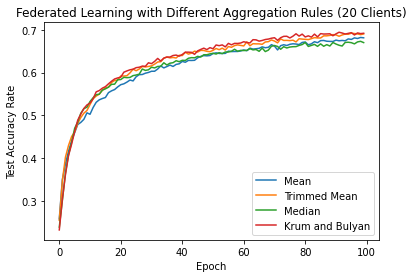

In [42]:
import matplotlib.pyplot as plt
Validation_acc_global_0_mean=[0.2582, 0.35, 0.3864, 0.4162, 0.44, 0.4598, 0.4786, 0.4836, 0.4908, 0.506, 0.5026, 0.5184, 0.5306, 0.5364, 0.5394, 0.5418, 0.5532, 0.5574, 0.5604, 0.5666, 0.5718, 0.5738, 0.5778, 0.5826, 0.5806, 0.5904, 0.5952, 0.5956, 0.5986, 0.6004, 0.6032, 0.6032, 0.6084, 0.6156, 0.611, 0.6142, 0.6176, 0.6144, 0.6192, 0.6206, 0.6262, 0.6242, 0.6286, 0.6284, 0.6288, 0.6346, 0.638, 0.6398, 0.6392, 0.64, 0.6446, 0.6462, 0.6448, 0.6448, 0.645, 0.6502, 0.6492, 0.6494, 0.6494, 0.6506, 0.653, 0.6512, 0.6572, 0.655, 0.6558, 0.6568, 0.6602, 0.6582, 0.6592, 0.6654, 0.662, 0.653, 0.663, 0.6652, 0.6634, 0.6662, 0.6674, 0.6668, 0.6656, 0.6706, 0.6716, 0.665, 0.6674, 0.6722, 0.67, 0.6748, 0.6752, 0.6734, 0.673, 0.6728, 0.676, 0.6744, 0.6752, 0.6744, 0.6788, 0.6776, 0.6812, 0.6798, 0.6822, 0.6814]
Validation_acc_global_0_trmean=[0.2548, 0.347, 0.4022, 0.4296, 0.4504, 0.4614, 0.481, 0.495, 0.5052, 0.5114, 0.5254, 0.5388, 0.5452, 0.5496, 0.5586, 0.5644, 0.566, 0.577, 0.5816, 0.5826, 0.5922, 0.592, 0.5928, 0.5994, 0.608, 0.6044, 0.6084, 0.6142, 0.6132, 0.6144, 0.6158, 0.6198, 0.6248, 0.6256, 0.6334, 0.6366, 0.6344, 0.6354, 0.6342, 0.6406, 0.6398, 0.6476, 0.6432, 0.6456, 0.6502, 0.6482, 0.652, 0.6518, 0.6498, 0.649, 0.652, 0.6564, 0.6536, 0.6572, 0.6528, 0.661, 0.6592, 0.6632, 0.6648, 0.6636, 0.6624, 0.672, 0.6628, 0.6676, 0.6672, 0.6672, 0.6662, 0.6716, 0.6724, 0.6764, 0.6738, 0.6696, 0.6788, 0.6752, 0.6754, 0.6748, 0.6758, 0.6718, 0.6792, 0.6784, 0.6778, 0.6772, 0.6794, 0.6818, 0.681, 0.681, 0.686, 0.686, 0.687, 0.6888, 0.6882, 0.685, 0.688, 0.6902, 0.6896, 0.6922, 0.6914, 0.6904, 0.6888, 0.6904]
Validation_acc_global_0_median=[0.2388, 0.301, 0.365, 0.4074, 0.4366, 0.4698, 0.4846, 0.505, 0.5156, 0.5192, 0.5324, 0.5412, 0.5484, 0.5496, 0.559, 0.562, 0.566, 0.5726, 0.573, 0.5834, 0.5838, 0.589, 0.5882, 0.5888, 0.593, 0.5944, 0.5964, 0.6084, 0.6052, 0.6066, 0.6126, 0.611, 0.6144, 0.6148, 0.623, 0.6178, 0.622, 0.6232, 0.6278, 0.6256, 0.6288, 0.6284, 0.6336, 0.635, 0.6346, 0.638, 0.6364, 0.6418, 0.6418, 0.6438, 0.6452, 0.6434, 0.6466, 0.6444, 0.6482, 0.6482, 0.65, 0.6546, 0.65, 0.652, 0.6516, 0.652, 0.656, 0.6532, 0.654, 0.6498, 0.6574, 0.6492, 0.6526, 0.6616, 0.6634, 0.6612, 0.6546, 0.6606, 0.6576, 0.6598, 0.6606, 0.6608, 0.6636, 0.6656, 0.6704, 0.6612, 0.6636, 0.666, 0.6614, 0.6672, 0.6616, 0.6654, 0.6622, 0.6704, 0.6668, 0.664, 0.6622, 0.6706, 0.671, 0.67, 0.6672, 0.6718, 0.6732, 0.6702]
Validation_acc_global_0_krum=[0.2322, 0.3038, 0.3614, 0.406, 0.4326, 0.4624, 0.4888, 0.503, 0.5162, 0.5244, 0.5288, 0.5388, 0.555, 0.558, 0.5636, 0.5672, 0.5738, 0.5798, 0.5852, 0.5876, 0.5894, 0.601, 0.604, 0.6066, 0.608, 0.6116, 0.6126, 0.6152, 0.6148, 0.623, 0.621, 0.6262, 0.6332, 0.627, 0.634, 0.6364, 0.6364, 0.64, 0.641, 0.6384, 0.6424, 0.6478, 0.6478, 0.6474, 0.6428, 0.6508, 0.6542, 0.6572, 0.6538, 0.6584, 0.6558, 0.6646, 0.663, 0.6648, 0.6602, 0.6684, 0.665, 0.6684, 0.6682, 0.6692, 0.6722, 0.6704, 0.6694, 0.677, 0.6766, 0.6736, 0.6752, 0.6774, 0.6784, 0.6804, 0.6816, 0.6754, 0.6816, 0.6848, 0.685, 0.681, 0.6852, 0.6908, 0.6854, 0.69, 0.6834, 0.686, 0.683, 0.69, 0.6836, 0.6912, 0.6902, 0.6904, 0.6908, 0.6862, 0.6906, 0.6944, 0.6926, 0.6902, 0.6918, 0.6934, 0.688, 0.6928, 0.6912, 0.692]
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(range(100),Validation_acc_global_0_mean,label='Mean')
ax.plot(range(100),Validation_acc_global_0_trmean,label='Trimmed Mean')
ax.plot(range(100),Validation_acc_global_0_median,label='Median')
ax.plot(range(100),Validation_acc_global_0_krum,label='Krum and Bulyan')
ax.set_title('Federated Learning with Different Aggregation Rules (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="lower right")
plt.show

<function matplotlib.pyplot.show>

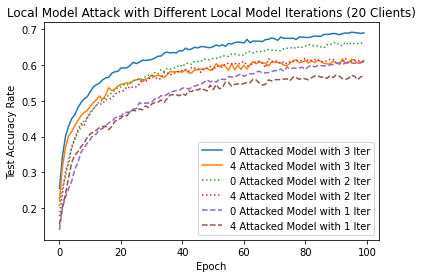

In [43]:
import matplotlib.pyplot as plt
Validation_acc_global_0_3iter=[0.2548, 0.347, 0.4022, 0.4296, 0.4504, 0.4614, 0.481, 0.495, 0.5052, 0.5114, 0.5254, 0.5388, 0.5452, 0.5496, 0.5586, 0.5644, 0.566, 0.577, 0.5816, 0.5826, 0.5922, 0.592, 0.5928, 0.5994, 0.608, 0.6044, 0.6084, 0.6142, 0.6132, 0.6144, 0.6158, 0.6198, 0.6248, 0.6256, 0.6334, 0.6366, 0.6344, 0.6354, 0.6342, 0.6406, 0.6398, 0.6476, 0.6432, 0.6456, 0.6502, 0.6482, 0.652, 0.6518, 0.6498, 0.649, 0.652, 0.6564, 0.6536, 0.6572, 0.6528, 0.661, 0.6592, 0.6632, 0.6648, 0.6636, 0.6624, 0.672, 0.6628, 0.6676, 0.6672, 0.6672, 0.6662, 0.6716, 0.6724, 0.6764, 0.6738, 0.6696, 0.6788, 0.6752, 0.6754, 0.6748, 0.6758, 0.6718, 0.6792, 0.6784, 0.6778, 0.6772, 0.6794, 0.6818, 0.681, 0.681, 0.686, 0.686, 0.687, 0.6888, 0.6882, 0.685, 0.688, 0.6902, 0.6896, 0.6922, 0.6914, 0.6904, 0.6888, 0.6904]
Validation_acc_global_4_3iter=[0.2202, 0.3172, 0.3714, 0.4026, 0.4142, 0.4312, 0.445, 0.4584, 0.4674, 0.4726, 0.485, 0.4952, 0.5028, 0.5138, 0.5032, 0.5158, 0.537, 0.529, 0.5332, 0.5414, 0.5462, 0.548, 0.5508, 0.5492, 0.5564, 0.559, 0.562, 0.5538, 0.5608, 0.5642, 0.5728, 0.568, 0.5728, 0.5686, 0.5658, 0.5726, 0.582, 0.5812, 0.5824, 0.5816, 0.5806, 0.587, 0.5786, 0.5782, 0.5868, 0.587, 0.589, 0.59, 0.5912, 0.5852, 0.5904, 0.604, 0.5958, 0.601, 0.5968, 0.5858, 0.604, 0.5868, 0.6002, 0.5884, 0.5994, 0.5894, 0.6008, 0.6102, 0.604, 0.61, 0.606, 0.6056, 0.5978, 0.6084, 0.6088, 0.6074, 0.606, 0.6002, 0.5986, 0.6056, 0.6124, 0.6152, 0.6066, 0.609, 0.6136, 0.6062, 0.612, 0.6074, 0.614, 0.6106, 0.6056, 0.6036, 0.6034, 0.6112, 0.6074, 0.6026, 0.6176, 0.6066, 0.6066, 0.6166, 0.6134, 0.605, 0.6056, 0.6134]
Validation_acc_global_0_2iter=[0.2066, 0.2598, 0.2878, 0.3366, 0.3686, 0.3924, 0.4124, 0.4266, 0.4434, 0.4522, 0.4684, 0.4772, 0.4884, 0.4978, 0.502, 0.5098, 0.5154, 0.5224, 0.5288, 0.5378, 0.5392, 0.5454, 0.5442, 0.5518, 0.5562, 0.5608, 0.5586, 0.562, 0.568, 0.5722, 0.5698, 0.5792, 0.5754, 0.587, 0.5826, 0.591, 0.5888, 0.5916, 0.5936, 0.601, 0.5956, 0.6048, 0.6054, 0.6026, 0.6104, 0.6102, 0.6106, 0.6174, 0.615, 0.6158, 0.619, 0.6192, 0.6216, 0.6266, 0.6254, 0.6246, 0.6312, 0.6314, 0.6286, 0.6282, 0.6278, 0.6368, 0.6378, 0.6342, 0.6382, 0.6372, 0.6398, 0.6396, 0.6438, 0.642, 0.6422, 0.64, 0.6406, 0.6462, 0.6474, 0.6474, 0.6506, 0.6464, 0.6518, 0.65, 0.6532, 0.658, 0.6558, 0.654, 0.6538, 0.6512, 0.6482, 0.6576, 0.6568, 0.6624, 0.664, 0.6564, 0.655, 0.6648, 0.657, 0.663, 0.6592, 0.6602, 0.6616, 0.6628]
Validation_acc_global_4_2iter=[0.177, 0.2426, 0.3052, 0.3244, 0.372, 0.395, 0.4184, 0.436, 0.4308, 0.452, 0.4646, 0.4766, 0.4882, 0.4912, 0.4912, 0.5036, 0.5042, 0.5082, 0.5176, 0.5254, 0.5248, 0.5292, 0.5404, 0.535, 0.5402, 0.5394, 0.5464, 0.5614, 0.5536, 0.5616, 0.5664, 0.5676, 0.5598, 0.5626, 0.5792, 0.5796, 0.5726, 0.578, 0.5778, 0.5842, 0.585, 0.5882, 0.5826, 0.5938, 0.592, 0.5918, 0.5798, 0.5898, 0.5914, 0.5968, 0.5852, 0.5978, 0.5956, 0.5944, 0.6048, 0.6052, 0.604, 0.6054, 0.6016, 0.6066, 0.611, 0.598, 0.5992, 0.606, 0.6092, 0.6106, 0.606, 0.5928, 0.618, 0.6108, 0.611, 0.6112, 0.6044, 0.6098, 0.6038, 0.6098, 0.6102, 0.6132, 0.6118, 0.6136, 0.6196, 0.6116, 0.614, 0.6158, 0.6158, 0.6098, 0.6092, 0.6124, 0.6168, 0.6164, 0.6062, 0.6058, 0.6094, 0.619, 0.6064, 0.6108, 0.6142, 0.6122, 0.613, 0.6094]
Validation_acc_global_0_1iter=[0.1388, 0.2018, 0.2318, 0.2546, 0.276, 0.3082, 0.3272, 0.3558, 0.369, 0.3814, 0.3922, 0.405, 0.4072, 0.42, 0.4226, 0.4296, 0.4384, 0.4426, 0.4518, 0.4568, 0.457, 0.4668, 0.4682, 0.469, 0.4772, 0.4782, 0.495, 0.4914, 0.4942, 0.4938, 0.4964, 0.5052, 0.5054, 0.5146, 0.5134, 0.5178, 0.5244, 0.5266, 0.5292, 0.53, 0.5356, 0.537, 0.533, 0.5376, 0.5418, 0.5442, 0.5472, 0.552, 0.559, 0.5532, 0.5568, 0.5522, 0.562, 0.5602, 0.56, 0.5678, 0.5672, 0.5674, 0.571, 0.576, 0.5686, 0.5732, 0.5758, 0.5758, 0.581, 0.5832, 0.5778, 0.5788, 0.5792, 0.5818, 0.5848, 0.5846, 0.5894, 0.583, 0.595, 0.589, 0.5922, 0.591, 0.5922, 0.5942, 0.5886, 0.596, 0.5988, 0.5952, 0.5988, 0.5986, 0.5982, 0.597, 0.6014, 0.6016, 0.6064, 0.605, 0.6016, 0.6058, 0.6066, 0.6068, 0.605, 0.608, 0.6084, 0.6086]
Validation_acc_global_4_1iter=[0.1542, 0.2044, 0.2404, 0.2856, 0.3282, 0.3484, 0.3576, 0.3716, 0.3818, 0.3968, 0.4076, 0.4128, 0.4176, 0.426, 0.428, 0.4298, 0.4194, 0.428, 0.4432, 0.4468, 0.4518, 0.4596, 0.4582, 0.4722, 0.4734, 0.4726, 0.4778, 0.475, 0.486, 0.4816, 0.4912, 0.495, 0.496, 0.5024, 0.4956, 0.5058, 0.5168, 0.5172, 0.517, 0.5144, 0.521, 0.5156, 0.5274, 0.526, 0.5324, 0.5306, 0.5354, 0.5316, 0.528, 0.5442, 0.5316, 0.5454, 0.534, 0.5368, 0.5532, 0.5514, 0.541, 0.5462, 0.5476, 0.547, 0.5488, 0.5512, 0.5512, 0.561, 0.5586, 0.5504, 0.5442, 0.5464, 0.5588, 0.5562, 0.5592, 0.5596, 0.5596, 0.5612, 0.5616, 0.5564, 0.5666, 0.5652, 0.5604, 0.5638, 0.5616, 0.559, 0.5648, 0.5698, 0.5708, 0.5662, 0.5678, 0.563, 0.5704, 0.5656, 0.5728, 0.5692, 0.5628, 0.56, 0.5632, 0.572, 0.5688, 0.5594, 0.5676, 0.5692]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(100),Validation_acc_global_0_3iter,label='0 Attacked Model with 3 Iter')
ax.plot(range(100),Validation_acc_global_4_3iter,label='4 Attacked Model with 3 Iter')
ax.plot(range(100),Validation_acc_global_0_2iter,label='0 Attacked Model with 2 Iter',linestyle=':')
ax.plot(range(100),Validation_acc_global_4_2iter,label='4 Attacked Model with 2 Iter',linestyle=':')
ax.plot(range(100),Validation_acc_global_0_1iter,label='0 Attacked Model with 1 Iter',linestyle='--')
ax.plot(range(100),Validation_acc_global_4_1iter,label='4 Attacked Model with 1 Iter',linestyle='--')
ax.set_title('Local Model Attack with Different Local Model Iterations (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="lower right")
plt.show

<function matplotlib.pyplot.show>

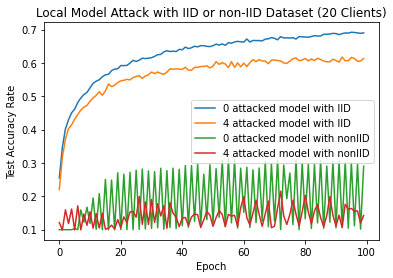

In [44]:
import matplotlib.pyplot as plt
Validation_acc_global_0_IID=[0.2548, 0.347, 0.4022, 0.4296, 0.4504, 0.4614, 0.481, 0.495, 0.5052, 0.5114, 0.5254, 0.5388, 0.5452, 0.5496, 0.5586, 0.5644, 0.566, 0.577, 0.5816, 0.5826, 0.5922, 0.592, 0.5928, 0.5994, 0.608, 0.6044, 0.6084, 0.6142, 0.6132, 0.6144, 0.6158, 0.6198, 0.6248, 0.6256, 0.6334, 0.6366, 0.6344, 0.6354, 0.6342, 0.6406, 0.6398, 0.6476, 0.6432, 0.6456, 0.6502, 0.6482, 0.652, 0.6518, 0.6498, 0.649, 0.652, 0.6564, 0.6536, 0.6572, 0.6528, 0.661, 0.6592, 0.6632, 0.6648, 0.6636, 0.6624, 0.672, 0.6628, 0.6676, 0.6672, 0.6672, 0.6662, 0.6716, 0.6724, 0.6764, 0.6738, 0.6696, 0.6788, 0.6752, 0.6754, 0.6748, 0.6758, 0.6718, 0.6792, 0.6784, 0.6778, 0.6772, 0.6794, 0.6818, 0.681, 0.681, 0.686, 0.686, 0.687, 0.6888, 0.6882, 0.685, 0.688, 0.6902, 0.6896, 0.6922, 0.6914, 0.6904, 0.6888, 0.6904]
Validation_acc_global_4_IID=[0.2202, 0.3172, 0.3714, 0.4026, 0.4142, 0.4312, 0.445, 0.4584, 0.4674, 0.4726, 0.485, 0.4952, 0.5028, 0.5138, 0.5032, 0.5158, 0.537, 0.529, 0.5332, 0.5414, 0.5462, 0.548, 0.5508, 0.5492, 0.5564, 0.559, 0.562, 0.5538, 0.5608, 0.5642, 0.5728, 0.568, 0.5728, 0.5686, 0.5658, 0.5726, 0.582, 0.5812, 0.5824, 0.5816, 0.5806, 0.587, 0.5786, 0.5782, 0.5868, 0.587, 0.589, 0.59, 0.5912, 0.5852, 0.5904, 0.604, 0.5958, 0.601, 0.5968, 0.5858, 0.604, 0.5868, 0.6002, 0.5884, 0.5994, 0.5894, 0.6008, 0.6102, 0.604, 0.61, 0.606, 0.6056, 0.5978, 0.6084, 0.6088, 0.6074, 0.606, 0.6002, 0.5986, 0.6056, 0.6124, 0.6152, 0.6066, 0.609, 0.6136, 0.6062, 0.612, 0.6074, 0.614, 0.6106, 0.6056, 0.6036, 0.6034, 0.6112, 0.6074, 0.6026, 0.6176, 0.6066, 0.6066, 0.6166, 0.6134, 0.605, 0.6056, 0.6134]
Validation_acc_global_0_nonIID=[0.0994, 0.0994, 0.0994, 0.0994, 0.0994, 0.1028, 0.0998, 0.1588, 0.122, 0.167, 0.1186, 0.1946, 0.1008, 0.2078, 0.0996, 0.2504, 0.0994, 0.2484, 0.0994, 0.2702, 0.0996, 0.2662, 0.0994, 0.2718, 0.0994, 0.278, 0.1006, 0.2816, 0.1016, 0.276, 0.1032, 0.2736, 0.1052, 0.284, 0.101, 0.277, 0.106, 0.2842, 0.1028, 0.281, 0.1114, 0.2918, 0.1068, 0.2922, 0.1244, 0.2962, 0.1116, 0.266, 0.1296, 0.2944, 0.119, 0.2826, 0.1364, 0.3084, 0.1094, 0.3124, 0.12, 0.3096, 0.1044, 0.2842, 0.1516, 0.2868, 0.106, 0.2792, 0.1204, 0.2848, 0.1256, 0.304, 0.1086, 0.2964, 0.1256, 0.3084, 0.0996, 0.2936, 0.1924, 0.2696, 0.115, 0.3092, 0.0996, 0.3, 0.1322, 0.2958, 0.1032, 0.2956, 0.1196, 0.3074, 0.1038, 0.2906, 0.122, 0.3036, 0.1052, 0.305, 0.1124, 0.303, 0.104, 0.301, 0.1112, 0.2962, 0.1012, 0.29]
Validation_acc_global_4_nonIID=[0.1208, 0.099, 0.1592, 0.1178, 0.1616, 0.0988, 0.1712, 0.099, 0.1464, 0.1126, 0.153, 0.104, 0.1478, 0.1044, 0.1488, 0.101, 0.104, 0.113, 0.1016, 0.1298, 0.105, 0.1378, 0.1212, 0.1528, 0.1542, 0.137, 0.1994, 0.1156, 0.1828, 0.1148, 0.1898, 0.121, 0.1774, 0.1406, 0.1714, 0.1036, 0.1806, 0.1492, 0.1374, 0.1086, 0.1344, 0.1362, 0.1114, 0.1376, 0.1468, 0.1444, 0.1062, 0.1296, 0.1542, 0.143, 0.1096, 0.1356, 0.1572, 0.145, 0.1088, 0.1456, 0.1402, 0.1426, 0.1096, 0.1652, 0.1984, 0.1354, 0.1138, 0.1496, 0.1878, 0.1456, 0.1096, 0.1474, 0.1852, 0.1054, 0.1098, 0.164, 0.2148, 0.1406, 0.1152, 0.1456, 0.1876, 0.1458, 0.1108, 0.1526, 0.2026, 0.1528, 0.1168, 0.1556, 0.1754, 0.1356, 0.109, 0.1414, 0.199, 0.1432, 0.11, 0.1432, 0.1056, 0.1758, 0.1608, 0.1632, 0.1548, 0.1558, 0.119, 0.1422]
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(range(100),Validation_acc_global_0_IID,label='0 attacked model with IID')
ax.plot(range(100),Validation_acc_global_4_IID,label='4 attacked model with IID')
ax.plot(range(100),Validation_acc_global_0_nonIID,label='0 attacked model with nonIID')
ax.plot(range(100),Validation_acc_global_4_nonIID,label='4 attacked model with nonIID')
ax.set_title('Local Model Attack with IID or non-IID Dataset (20 Clients)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy Rate')
plt.legend(frameon=True,loc="right")
plt.show